In [1]:

import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")


In [2]:
number_bucket = 10

In [3]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}_{number_bucket}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')


=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 14:09:40+00:00, Price = 121935.42
Trough: 2025-10-10 21:21:10+00:00, Price = 104753.31
End   : 2025-10-10 23:56:57+00:00,   Price = 113946.55


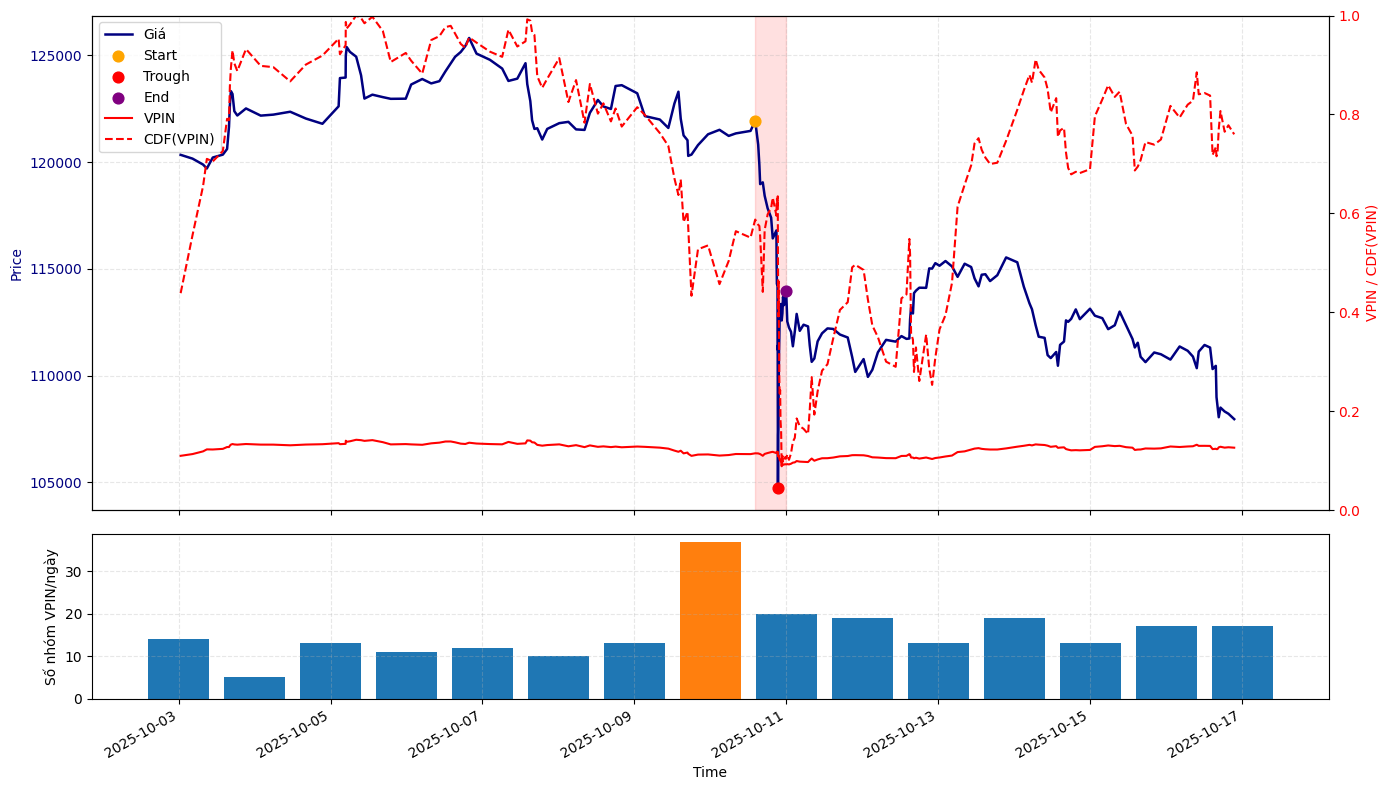

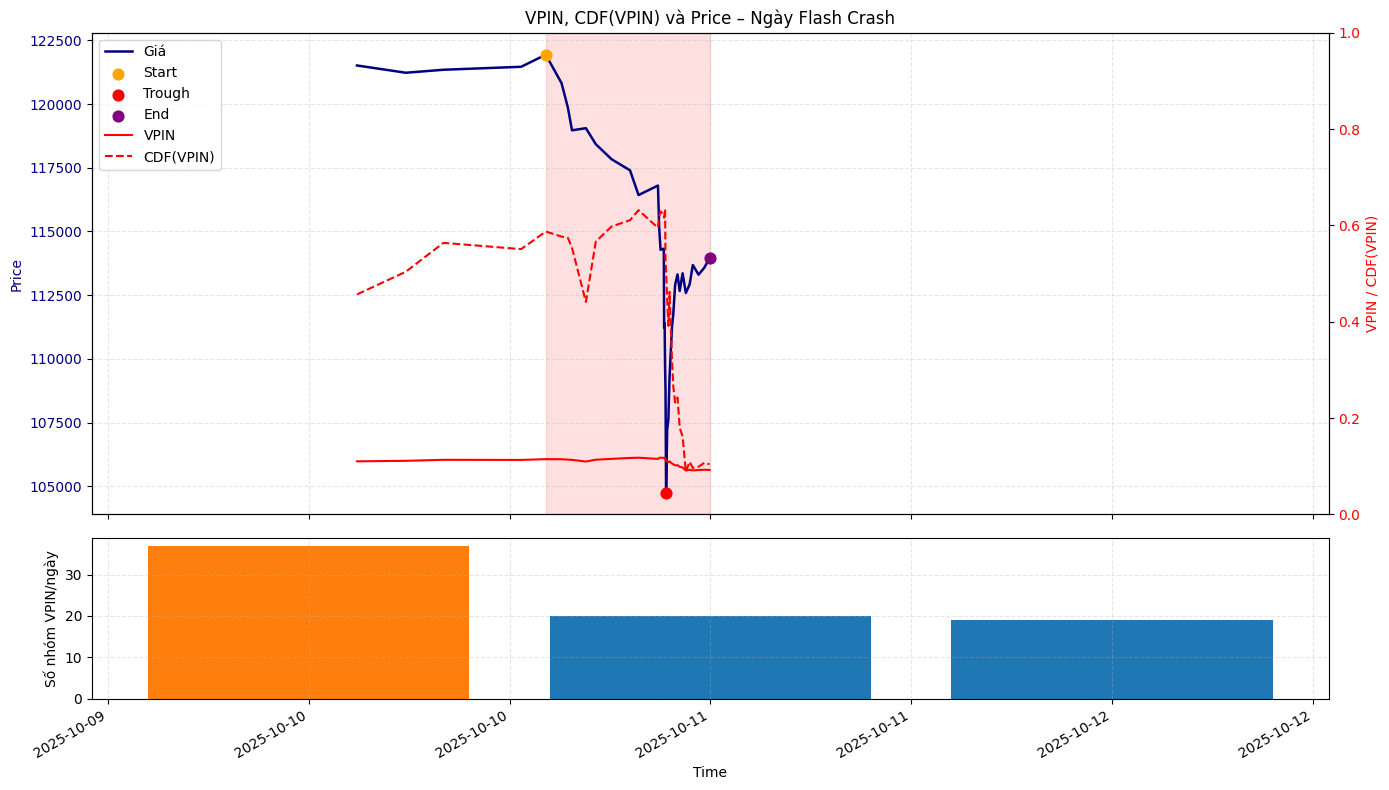

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (code của bạn, giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ: 2 SUBPLOT (PRICE+VPIN+CDF / SỐ NHÓM VPIN MỖI NGÀY)
# ======================================================

def plot_vpin_price_and_bucket_counts(df, start_time, end_time,
                                      start_fc, trough_fc, end_fc,
                                      flash_crash_date,
                                      title=""):
    """
    df: DataFrame index = Time, có cột Price, VPIN, CDF
    start_time, end_time: khoảng thời gian để vẽ (Timestamp)
    start_fc, trough_fc, end_fc: 3 mốc flash crash (Timestamp)
    flash_crash_date: ngày chứa flash crash (Timestamp.normalize())
    """

    # Cắt window
    df_win = df.loc[start_time:end_time].copy()

    # Chuẩn bị daily counts VPIN
    daily_counts_all = df["VPIN"].resample("D").count()
    # Lấy phần ngày nằm trong [start_time, end_time]
    day_start = start_time.normalize()
    day_end = (end_time + pd.Timedelta(days=1)).normalize()
    daily_counts = daily_counts_all.loc[day_start:day_end]

    # Colors: tô cam cho ngày có flash crash
    colors = [
        "tab:orange" if d.normalize() == flash_crash_date else "tab:blue"
        for d in daily_counts.index
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(14, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---------------- TOP: PRICE (trục trái) + VPIN, CDF (trục phải) ----------------
    # Price – trục trái
    ax_price = ax_top
    ax_price.plot(df_win.index, df_win["Price"],
                  color="navy", linewidth=1.8, label="Giá")
    ax_price.set_ylabel("Price", color="navy")
    ax_price.tick_params(axis="y", labelcolor="navy")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # VPIN & CDF – trục phải
    ax_vpin = ax_price.twinx()
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="red", linewidth=1.5, label="VPIN")
    ax_vpin.plot(df_win.index, df_win["CDF"],
                 color="red", linestyle="--", linewidth=1.5, label="CDF(VPIN)")
    ax_vpin.set_ylabel("VPIN / CDF(VPIN)", color="red")
    ax_vpin.tick_params(axis="y", labelcolor="red")
    ax_vpin.set_ylim(0, max(1, df_win["VPIN"].max()*1.1))

    # Đánh dấu 3 điểm flash crash trên đường giá
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="orange", s=60, zorder=5, label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="red", s=60, zorder=5, label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="purple", s=60, zorder=5, label="End")

    # Có thể tô background vùng crash nếu muốn
    ax_price.axvspan(start_fc, end_fc, color="red", alpha=0.12)

    # Legend gộp cả 2 trục
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_vpin.get_legend_handles_labels()
    ax_top.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_top.set_title(title)

    # ---------------- BOTTOM: SỐ NHÓM VPIN MỖI NGÀY ----------------
    ax_bot.bar(daily_counts.index, daily_counts.values,
               color=colors, width=0.8)
    ax_bot.set_ylabel("Số nhóm VPIN/ngày")
    ax_bot.grid(True, linestyle="--", alpha=0.3)

    # Format trục thời gian
    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax_bot.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_bot.get_xticklabels(), rotation=30, ha="right")

    ax_bot.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

# ======================================================
# 3. VẼ 2 BIỂU ĐỒ:
#    (1) 1 TUẦN TRƯỚC & SAU NGÀY FLASH CRASH
#    (2) RIÊNG NGÀY FLASH CRASH
# ======================================================

# (1) 1 tuần trước & sau
week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    # title="VPIN, CDF(VPIN) và Price – 1 tuần trước & sau Flash Crash"
)

# (2) Ngày flash crash
day_start = flash_crash_date
day_end   = flash_crash_date + pd.Timedelta(days=1)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    title="VPIN, CDF(VPIN) và Price – Ngày Flash Crash"
)


In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_vpin_cdf_only(df, start_time, end_time,
                       start_fc, trough_fc, end_fc,
                       title="VPIN và CDF(VPIN)"):
    """
    df        : DataFrame index = Time, có cột VPIN, CDF
    start_time, end_time : khoảng thời gian để vẽ
    start_fc, trough_fc, end_fc : 3 mốc flash crash (Timestamp)
    """

    df_win = df.loc[start_time:end_time].copy()

    fig, ax_vpin = plt.subplots(figsize=(14, 4))

    # ===== VPIN (trục trái) =====
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="green", linewidth=1.6, label="VPIN")
    ax_vpin.set_ylabel("VPIN", color="green")
    ax_vpin.tick_params(axis="y", labelcolor="green")
    ax_vpin.grid(True, linestyle="--", alpha=0.3)

    # scale VPIN theo biên độ thực tế
    vpmax = df_win["VPIN"].max()
    vpmin = df_win["VPIN"].min()
    eps = (vpmax - vpmin) * 0.2
    if eps == 0:
        eps = max(vpmax, 1e-6) * 0.1
    ax_vpin.set_ylim(vpmin - eps, vpmax + eps)

    # ===== CDF (trục phải) =====
    ax_cdf = ax_vpin.twinx()
    ax_cdf.plot(df_win.index, df_win["CDF"],
                color="red", linestyle="--", linewidth=1.6, label="CDF(VPIN)")
    ax_cdf.set_ylabel("CDF(VPIN)", color="red")
    ax_cdf.tick_params(axis="y", labelcolor="red")
    ax_cdf.set_ylim(0, 1.05)

    # ===== chỉ vẽ "đường flash crash" =====
    # tô vùng từ start -> end
    ax_vpin.axvspan(start_fc, end_fc, color="red", alpha=0.12)
    # vẽ 1 đường thẳng tại đáy (trough)
    ax_vpin.axvline(trough_fc, color="red", linestyle=":", linewidth=1.5)

    # ===== format time & legend =====
    ax_vpin.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    ax_vpin.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_vpin.get_xticklabels(), rotation=30, ha="right")

    # gộp legend 2 trục
    lines1, labels1 = ax_vpin.get_legend_handles_labels()
    lines2, labels2 = ax_cdf.get_legend_handles_labels()
    ax_vpin.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_vpin.set_title(title)
    plt.tight_layout()
    plt.show()


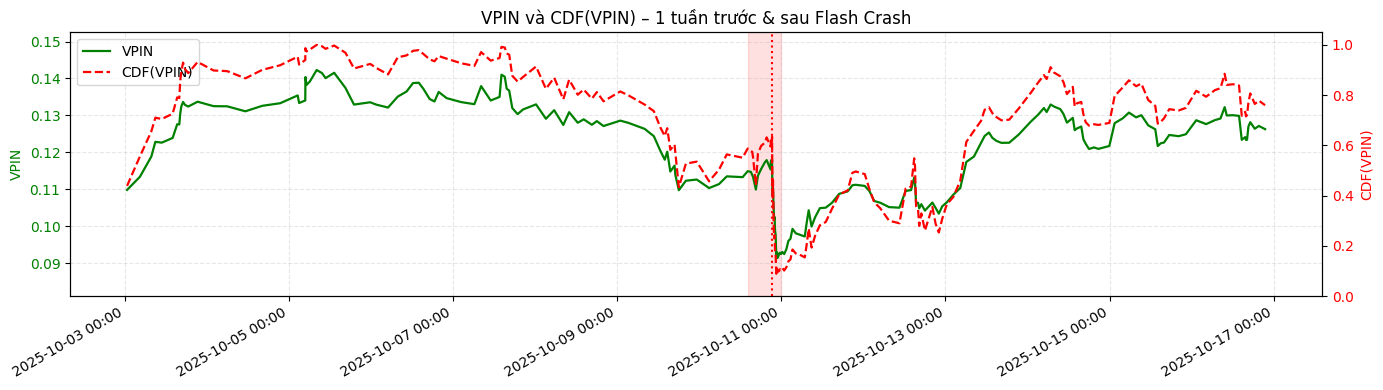

In [6]:
plot_vpin_cdf_only(
    df,
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="VPIN và CDF(VPIN) – 1 tuần trước & sau Flash Crash"
)



=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 14:09:40+00:00, Price = 121935.42
Trough: 2025-10-10 21:21:10+00:00, Price = 104753.31
End   : 2025-10-10 23:56:57+00:00,   Price = 113946.55


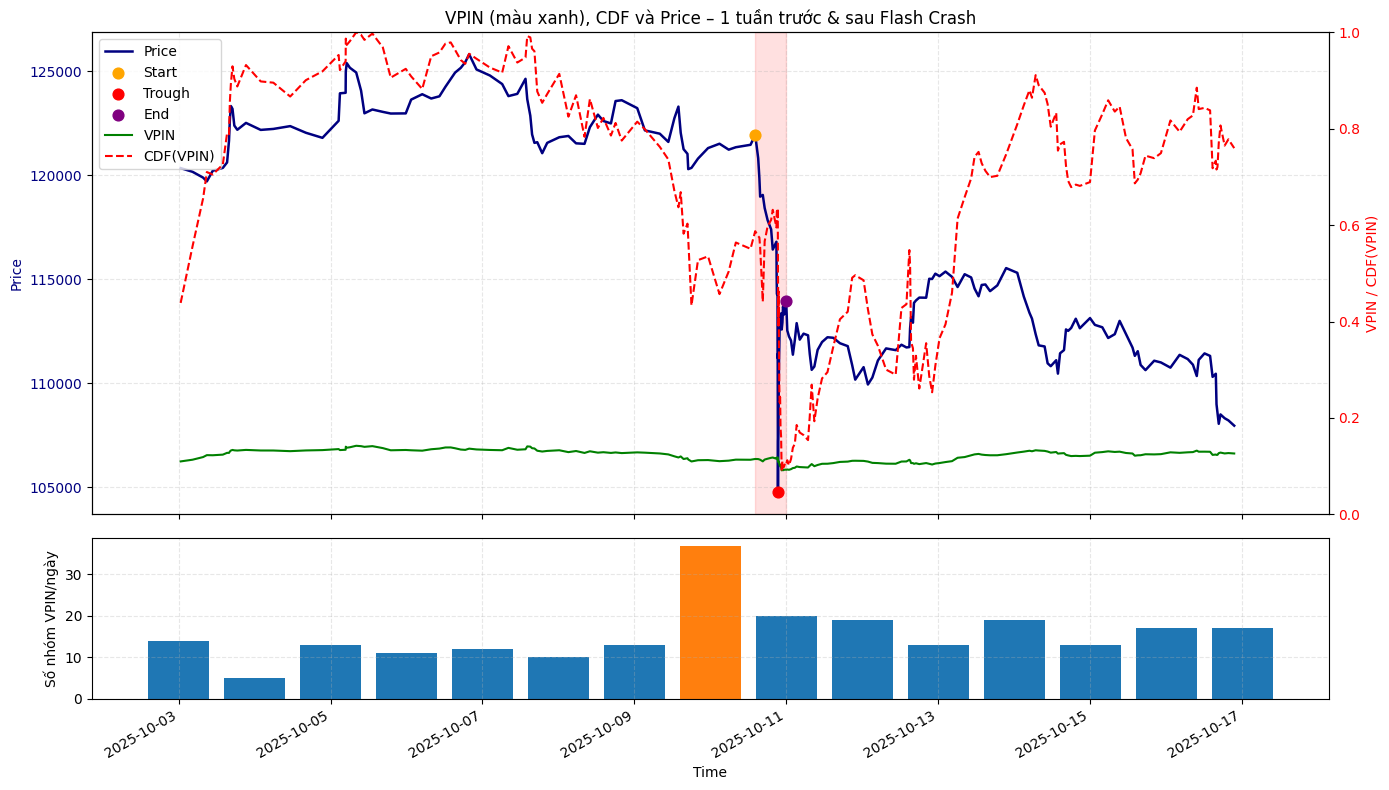

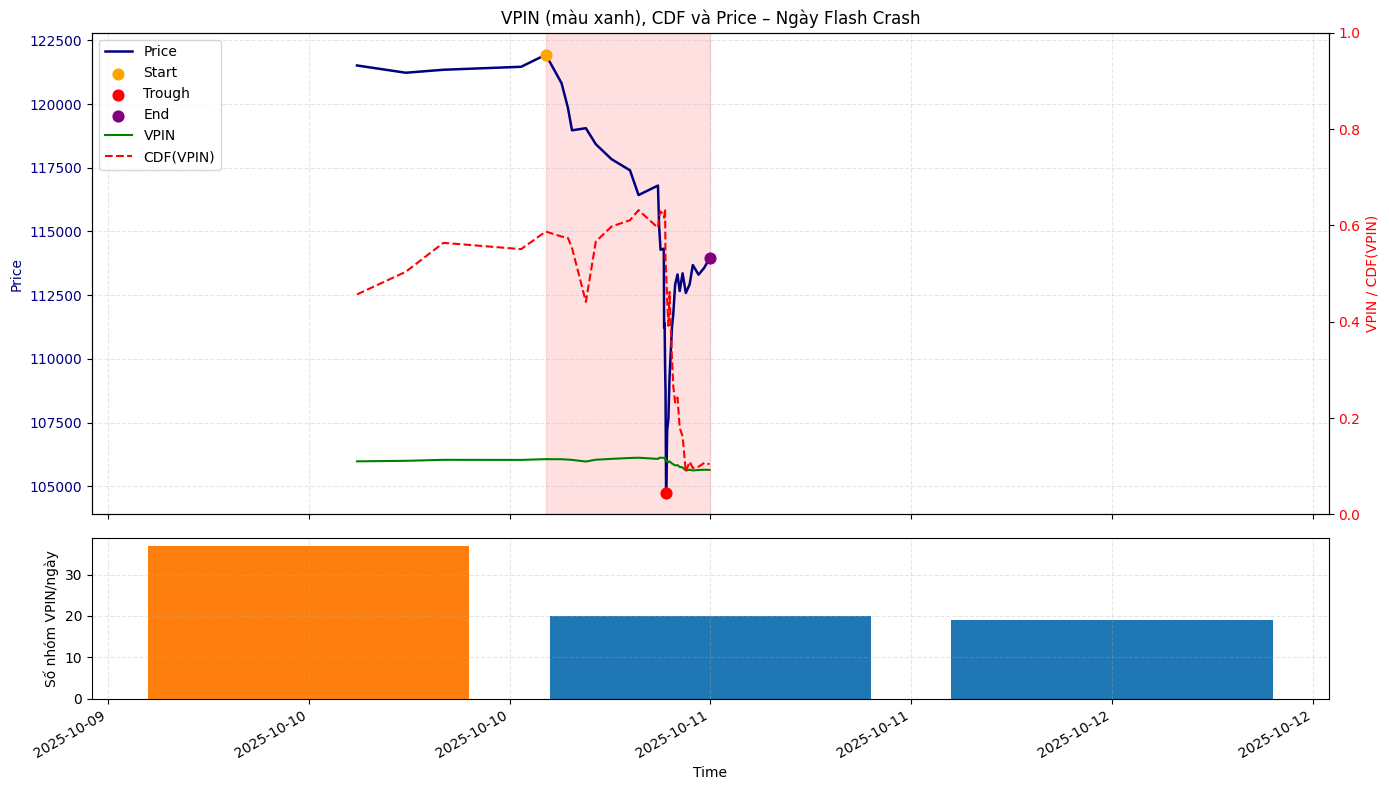

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (code của bạn, giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ (VPIN = màu xanh)
# ======================================================

def plot_vpin_price_and_bucket_counts(df, start_time, end_time,
                                      start_fc, trough_fc, end_fc,
                                      flash_crash_date,
                                      title=""):
    df_win = df.loc[start_time:end_time].copy()

    # Daily VPIN count
    daily_counts_all = df["VPIN"].resample("D").count()
    day_start = start_time.normalize()
    day_end = (end_time + pd.Timedelta(days=1)).normalize()
    daily_counts = daily_counts_all.loc[day_start:day_end]

    colors = [
        "tab:orange" if d.normalize() == flash_crash_date else "tab:blue"
        for d in daily_counts.index
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(14, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ==== TOP PLOT ====
    ax_price = ax_top
    ax_price.plot(df_win.index, df_win["Price"],
                  color="navy", linewidth=1.8, label="Price")
    ax_price.set_ylabel("Price", color="navy")
    ax_price.tick_params(axis="y", labelcolor="navy")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # VPIN = màu xanh
    ax_vpin = ax_price.twinx()
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="green", linewidth=1.5, label="VPIN")   # <=== CHỈNH Ở ĐÂY
    ax_vpin.plot(df_win.index, df_win["CDF"],
                 color="red", linestyle="--", linewidth=1.5, label="CDF(VPIN)")
    ax_vpin.set_ylabel("VPIN / CDF(VPIN)", color="red")
    ax_vpin.tick_params(axis="y", labelcolor="red")
    ax_vpin.set_ylim(0, max(1, df_win["VPIN"].max()*1.1))

    # Flash crash markers
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="orange", s=60, zorder=5, label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="red", s=60, zorder=5, label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="purple", s=60, zorder=5, label="End")

    ax_price.axvspan(start_fc, end_fc, color="red", alpha=0.12)

    # Legend merge
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_vpin.get_legend_handles_labels()
    ax_top.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    ax_top.set_title(title)

    # ==== BOTTOM PLOT ====
    ax_bot.bar(daily_counts.index, daily_counts.values,
               color=colors, width=0.8)
    ax_bot.set_ylabel("Số nhóm VPIN/ngày")
    ax_bot.grid(True, linestyle="--", alpha=0.3)

    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax_bot.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_bot.get_xticklabels(), rotation=30, ha="right")

    ax_bot.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

# ======================================================
# 3. VẼ BIỂU ĐỒ
# ======================================================

week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    title="VPIN (màu xanh), CDF và Price – 1 tuần trước & sau Flash Crash"
)

day_start = flash_crash_date
day_end   = flash_crash_date + pd.Timedelta(days=1)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    title="VPIN (màu xanh), CDF và Price – Ngày Flash Crash"
)



=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 14:09:40+00:00, Price = 121935.42
Trough: 2025-10-10 21:21:10+00:00, Price = 104753.31
End   : 2025-10-10 23:56:57+00:00,   Price = 113946.55


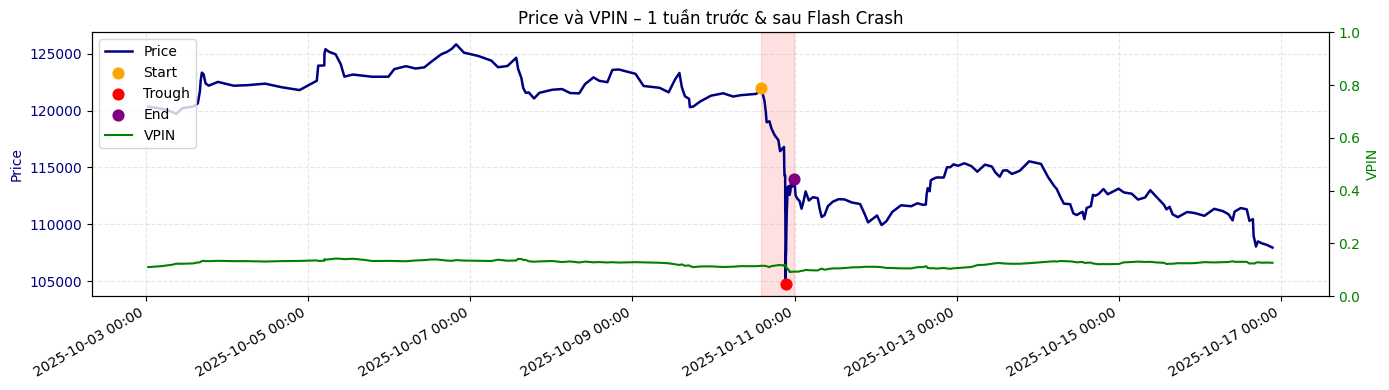

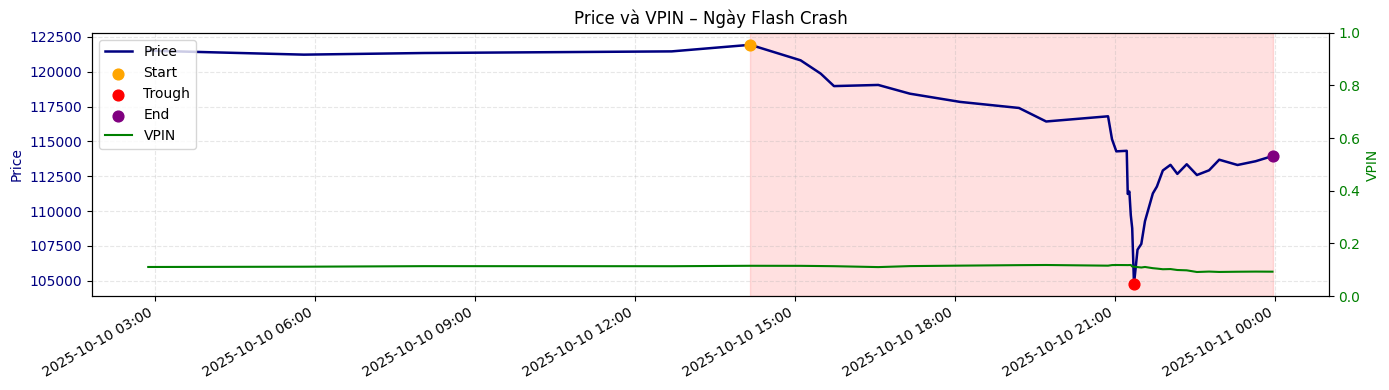

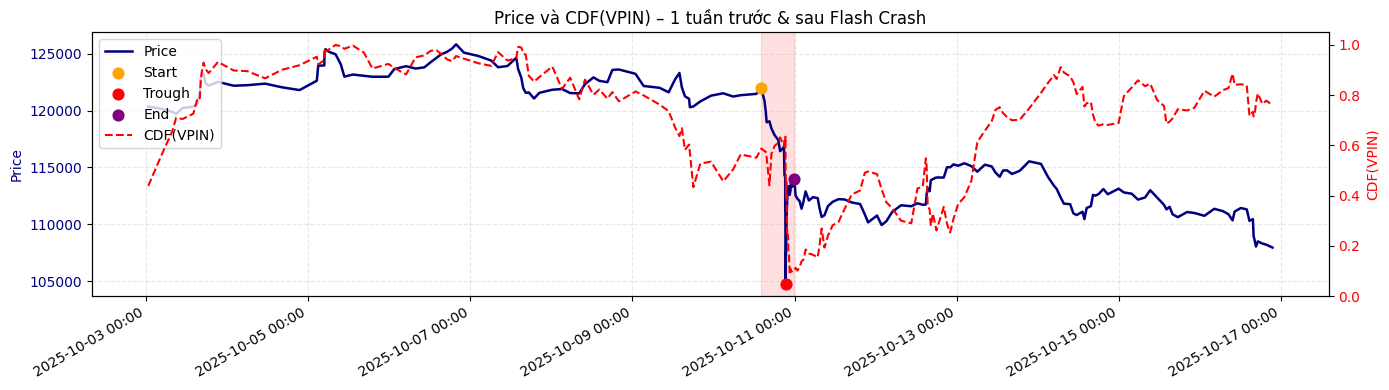

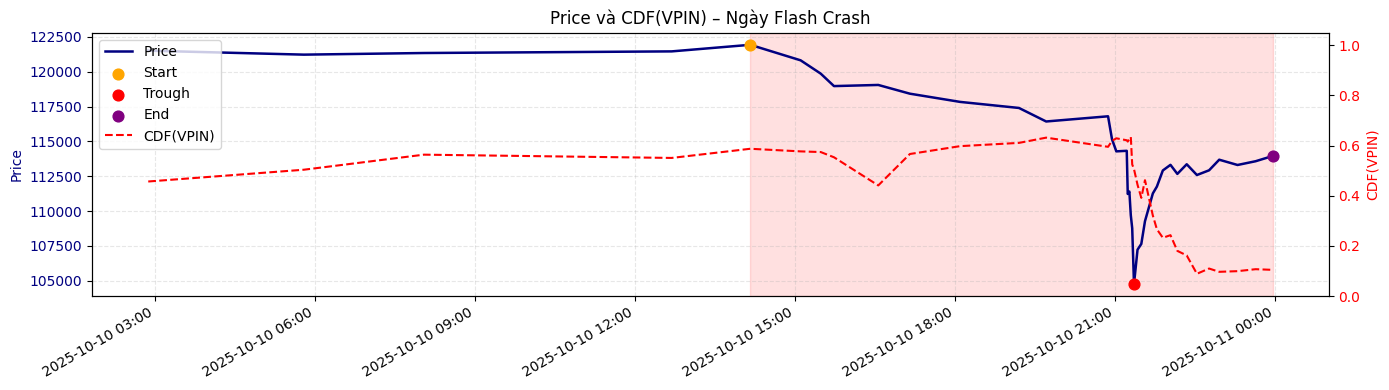

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ: 1 BIỂU ĐỒ (PRICE + 1 CHỈ BÁO: VPIN hoặc CDF)
# ======================================================

def plot_price_with_metric(df, metric_col, start_time, end_time,
                           start_fc, trough_fc, end_fc,
                           title=""):
    """
    df        : DataFrame index = Time, có cột Price, VPIN, CDF
    metric_col: 'VPIN' hoặc 'CDF'
    start_time, end_time: khoảng thời gian để vẽ (Timestamp)
    start_fc, trough_fc, end_fc: 3 mốc flash crash (Timestamp)
    """

    df_win = df.loc[start_time:end_time].copy()

    fig, ax_price = plt.subplots(figsize=(14, 4))

    # ---------------- PRICE (trục trái) ----------------
    ax_price.plot(df_win.index, df_win["Price"],
                  color="navy", linewidth=1.8, label="Price")
    ax_price.set_ylabel("Price", color="navy")
    ax_price.tick_params(axis="y", labelcolor="navy")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # ---------------- METRIC (trục phải) ----------------
    ax_metric = ax_price.twinx()

    if metric_col == "VPIN":
        color = "green"
        label = "VPIN"
        ax_metric.plot(df_win.index, df_win["VPIN"],
                       color=color, linewidth=1.5, label=label)
        ax_metric.set_ylabel("VPIN", color=color)
        ax_metric.tick_params(axis="y", labelcolor=color)
        ax_metric.set_ylim(0, max(1, df_win["VPIN"].max() * 1.1))
    elif metric_col == "CDF":
        color = "red"
        label = "CDF(VPIN)"
        ax_metric.plot(df_win.index, df_win["CDF"],
                       color=color, linestyle="--", linewidth=1.5, label=label)
        ax_metric.set_ylabel("CDF(VPIN)", color=color)
        ax_metric.tick_params(axis="y", labelcolor=color)
        ax_metric.set_ylim(0, 1.05)  # CDF ~ [0,1]

    # ---------------- ĐÁNH DẤU FLASH CRASH TRÊN GIÁ ----------------
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="orange", s=60, zorder=5, label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="red", s=60, zorder=5, label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="purple", s=60, zorder=5, label="End")

    ax_price.axvspan(start_fc, end_fc, color="red", alpha=0.12)

    # ---------------- FORMAT THỜI GIAN + LEGEND ----------------
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    ax_price.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_price.get_xticklabels(), rotation=30, ha="right")

    # Gộp legend 2 trục
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_metric.get_legend_handles_labels()
    ax_price.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_price.set_title(title)
    plt.tight_layout()
    plt.show()

# ======================================================
# 3. XÁC ĐỊNH CÁC WINDOW THỜI GIAN
# ======================================================

# (1) 1 tuần trước & sau flash crash
week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

# (2) Riêng ngày flash crash
day_start = flash_crash_date
day_end   = flash_crash_date + pd.Timedelta(days=1)

# ======================================================
# 4. VẼ 4 BIỂU ĐỒ TÁCH RIÊNG
#    (a) Price + VPIN – 1 tuần
#    (b) Price + VPIN – ngày flash crash
#    (c) Price + CDF – 1 tuần
#    (d) Price + CDF – ngày flash crash
# ======================================================

# (a) Price + VPIN – 1 tuần trước & sau
plot_price_with_metric(
    df,
    metric_col="VPIN",
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và VPIN – 1 tuần trước & sau Flash Crash"
)

# (b) Price + VPIN – ngày flash crash
plot_price_with_metric(
    df,
    metric_col="VPIN",
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và VPIN – Ngày Flash Crash"
)

# (c) Price + CDF – 1 tuần trước & sau
plot_price_with_metric(
    df,
    metric_col="CDF",
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và CDF(VPIN) – 1 tuần trước & sau Flash Crash"
)

# (d) Price + CDF – ngày flash crash
plot_price_with_metric(
    df,
    metric_col="CDF",
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và CDF(VPIN) – Ngày Flash Crash"
)



=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 14:09:40+00:00, Price = 121935.42
Trough: 2025-10-10 21:21:10+00:00, Price = 104753.31
End   : 2025-10-10 23:56:57+00:00,   Price = 113946.55


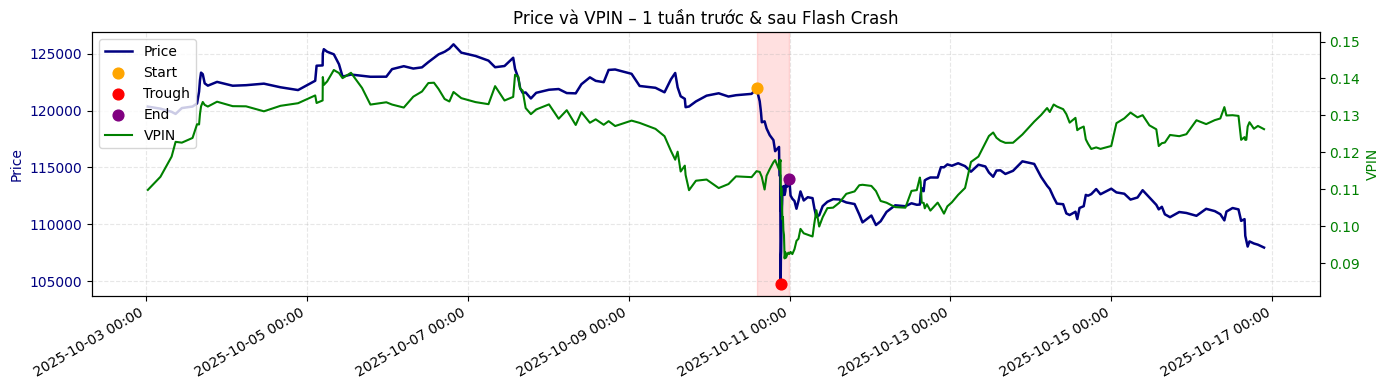

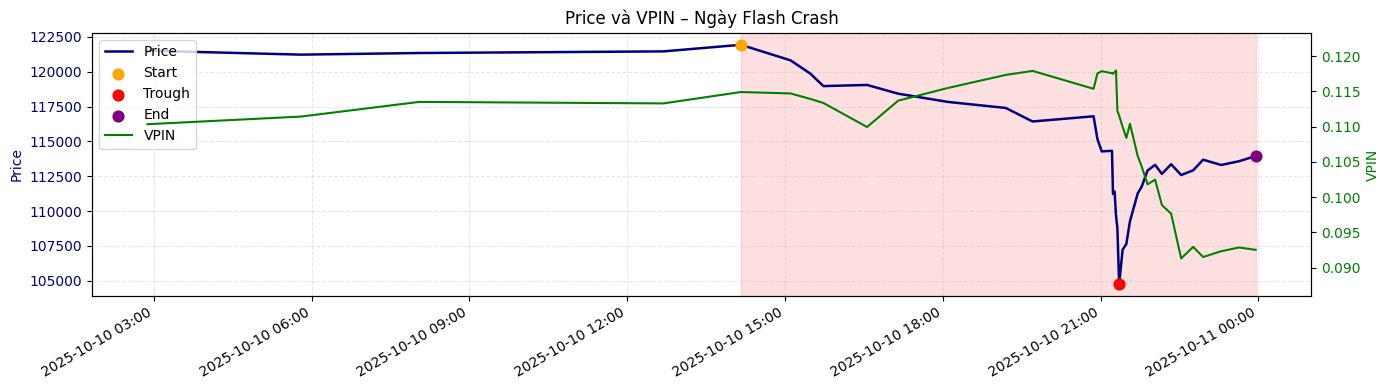

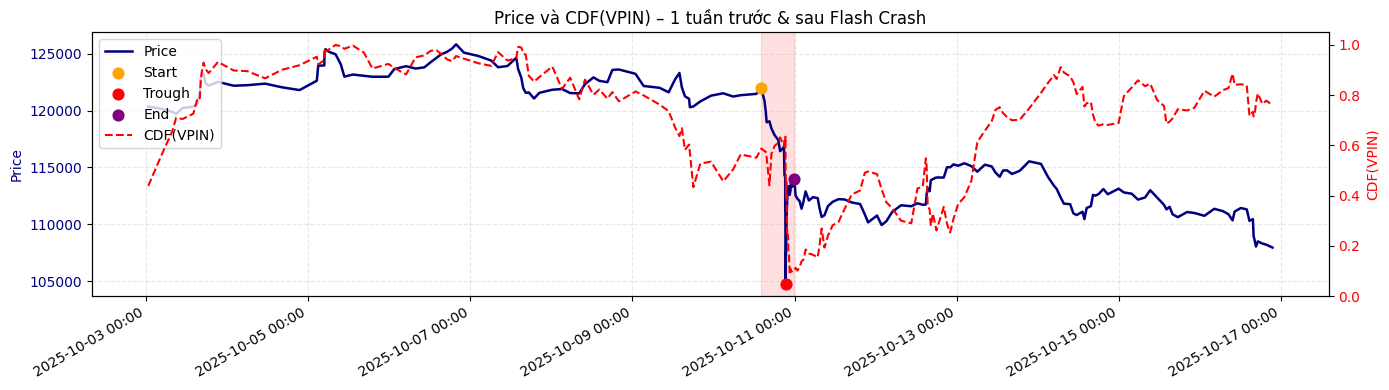

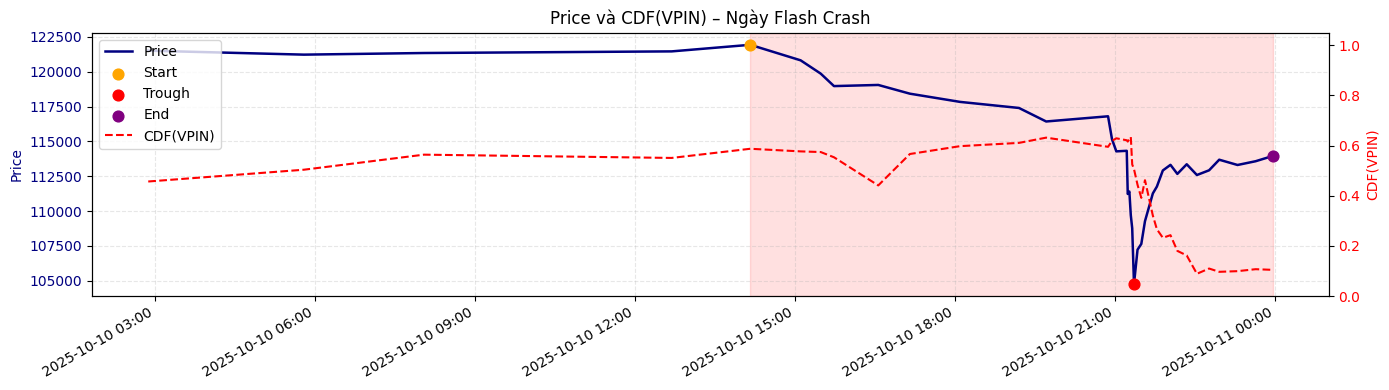

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ: 1 BIỂU ĐỒ (PRICE + 1 CHỈ BÁO: VPIN hoặc CDF)
# ======================================================

def plot_price_with_metric(df, metric_col, start_time, end_time,
                           start_fc, trough_fc, end_fc,
                           title=""):
    """
    df        : DataFrame index = Time, có cột Price, VPIN, CDF
    metric_col: 'VPIN' hoặc 'CDF'
    start_time, end_time: khoảng thời gian để vẽ (Timestamp)
    start_fc, trough_fc, end_fc: 3 mốc flash crash (Timestamp)
    """

    df_win = df.loc[start_time:end_time].copy()

    fig, ax_price = plt.subplots(figsize=(14, 4))

    # ---------------- PRICE (trục trái) ----------------
    ax_price.plot(df_win.index, df_win["Price"],
                  color="navy", linewidth=1.8, label="Price")
    ax_price.set_ylabel("Price", color="navy")
    ax_price.tick_params(axis="y", labelcolor="navy")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # ---------------- METRIC (trục phải) ----------------
    ax_metric = ax_price.twinx()

    if metric_col == "VPIN":
        color = "green"
        label = "VPIN"
        ax_metric.plot(df_win.index, df_win["VPIN"],
                       color=color, linewidth=1.5, label=label)
        ax_metric.set_ylabel("VPIN", color=color)
        ax_metric.tick_params(axis="y", labelcolor=color)

        # ==== SCALE VPIN THEO BIÊN ĐỘ THỰC TẾ ====
        vpmax = df_win["VPIN"].max()
        vpmin = df_win["VPIN"].min()
        # thêm buffer 20% mỗi bên cho dễ nhìn
        eps = (vpmax - vpmin) * 0.2
        if eps == 0:        # trường hợp VPIN gần như constant
            eps = max(vpmax, 1e-6) * 0.1
        ax_metric.set_ylim(vpmin - eps, vpmax + eps)

    elif metric_col == "CDF":
        color = "red"
        label = "CDF(VPIN)"
        ax_metric.plot(df_win.index, df_win["CDF"],
                       color=color, linestyle="--", linewidth=1.5, label=label)
        ax_metric.set_ylabel("CDF(VPIN)", color=color)
        ax_metric.tick_params(axis="y", labelcolor=color)
        ax_metric.set_ylim(0, 1.05)  # CDF ~ [0,1]

    # ---------------- ĐÁNH DẤU FLASH CRASH TRÊN GIÁ ----------------
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="orange", s=60, zorder=5, label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="red", s=60, zorder=5, label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="purple", s=60, zorder=5, label="End")

    ax_price.axvspan(start_fc, end_fc, color="red", alpha=0.12)

    # ---------------- FORMAT THỜI GIAN + LEGEND ----------------
    ax_price.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    ax_price.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_price.get_xticklabels(), rotation=30, ha="right")

    # Gộp legend 2 trục
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_metric.get_legend_handles_labels()
    ax_price.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_price.set_title(title)
    plt.tight_layout()
    plt.show()

# ======================================================
# 3. XÁC ĐỊNH CÁC WINDOW THỜI GIAN
# ======================================================

# (1) 1 tuần trước & sau flash crash
week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

# (2) Riêng ngày flash crash
day_start = flash_crash_date
day_end   = flash_crash_date + pd.Timedelta(days=1)

# ======================================================
# 4. VẼ 4 BIỂU ĐỒ TÁCH RIÊNG
#    (a) Price + VPIN – 1 tuần
#    (b) Price + VPIN – ngày flash crash
#    (c) Price + CDF – 1 tuần
#    (d) Price + CDF – ngày flash crash
# ======================================================

# (a) Price + VPIN – 1 tuần trước & sau
plot_price_with_metric(
    df,
    metric_col="VPIN",
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và VPIN – 1 tuần trước & sau Flash Crash"
)

# (b) Price + VPIN – ngày flash crash
plot_price_with_metric(
    df,
    metric_col="VPIN",
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và VPIN – Ngày Flash Crash"
)

# (c) Price + CDF – 1 tuần trước & sau
plot_price_with_metric(
    df,
    metric_col="CDF",
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và CDF(VPIN) – 1 tuần trước & sau Flash Crash"
)

# (d) Price + CDF – ngày flash crash
plot_price_with_metric(
    df,
    metric_col="CDF",
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    title="Price và CDF(VPIN) – Ngày Flash Crash"
)



=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 14:09:40+00:00, Price = 121935.42
Trough: 2025-10-10 21:21:10+00:00, Price = 104753.31
End   : 2025-10-10 23:56:57+00:00,   Price = 113946.55


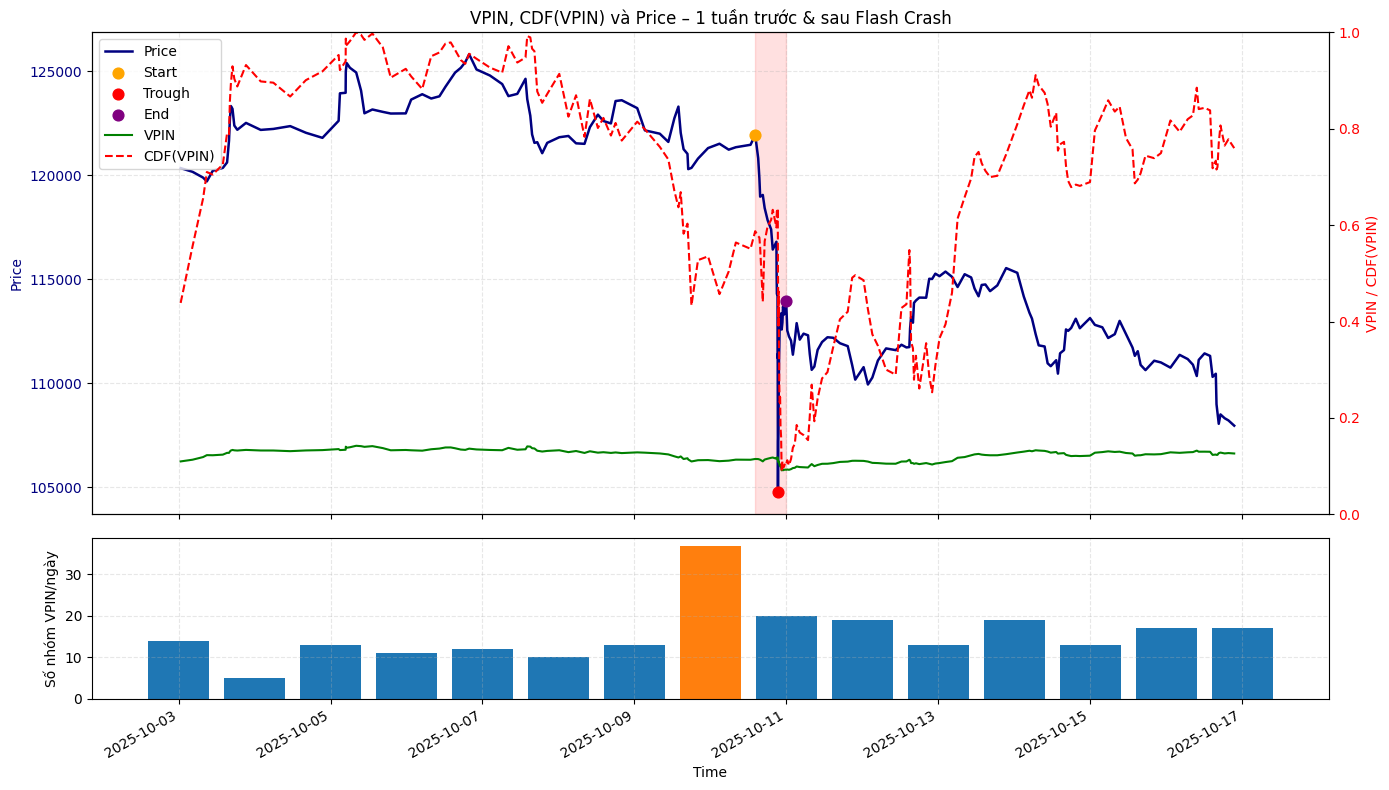

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (code của bạn, giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ: 2 SUBPLOT (PRICE+VPIN+CDF / SỐ NHÓM VPIN MỖI NGÀY)
# ======================================================

def plot_vpin_price_and_bucket_counts_pretty(df, start_time, end_time,
                                             start_fc, trough_fc, end_fc,
                                             flash_crash_date,
                                             title=""):
    """
    df: DataFrame index = Time, có Price, VPIN, CDF
    """

    # --- Lấy dữ liệu trong cửa sổ ---
    df_win = df.loc[start_time:end_time].copy()

    # --- Dữ liệu nhóm VPIN mỗi ngày ---
    daily_counts_all = df["VPIN"].resample("D").count()
    day_start = start_time.normalize()
    day_end   = (end_time + pd.Timedelta(days=1)).normalize()
    daily_counts = daily_counts_all.loc[day_start:day_end]

    colors = [
        "#f4a261" if d.normalize() == flash_crash_date else "#4682b4"
        for d in daily_counts.index
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(14, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ============================
    # (A) TOP PLOT – PRICE + VPIN + CDF(VPIN)
    # ============================

    # Price (navy)
    ax_price = ax_top
    ax_price.plot(df_win.index, df_win["Price"],
                  color="#1f4e79", linewidth=2.2, label="Price")
    ax_price.set_ylabel("Price", color="#1f4e79")
    ax_price.tick_params(axis="y", labelcolor="#1f4e79")
    ax_price.grid(True, linestyle="--", alpha=0.25)

    # VPIN (GREEN) & CDF (RED DASHED)
    ax_vpin = ax_price.twinx()

    # VPIN – green
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="#2a9d8f", linewidth=2.0, label="VPIN")

    # CDF(VPIN) – red dashed
    ax_vpin.plot(df_win.index, df_win["CDF"],
                 color="#d62728", linestyle="--", linewidth=2.0, label="CDF(VPIN)")

    ax_vpin.set_ylabel("VPIN / CDF(VPIN)", color="#2a9d8f")
    ax_vpin.tick_params(axis="y", labelcolor="#2a9d8f")
    ax_vpin.set_ylim(0, max(1, df_win["VPIN"].max() * 1.15))

    # Flash crash markers
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="#e76f51", s=120, marker="v", label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="#d62828", s=150, marker="o", label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="#2a9d8f", s=120, marker="^", label="End")

    # Background crash region
    ax_price.axvspan(start_fc, end_fc, color="#e76f51", alpha=0.12)

    # Legend
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_vpin.get_legend_handles_labels()
    ax_top.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_top.set_title(title, fontsize=15, fontweight="bold", pad=15)

    # ============================
    # (B) BOTTOM PLOT – DAILY VPIN BUCKET COUNT
    # ============================

    ax_bot.bar(daily_counts.index, daily_counts.values,
               color=colors, width=0.6, alpha=0.85)

    ax_bot.set_ylabel("VPIN Buckets / Day")
    ax_bot.set_xlabel("Time")

    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax_bot.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_bot.get_xticklabels(), rotation=30, ha="right")

    plt.tight_layout()
    plt.show()



# ======================================================
# 3. VẼ 2 BIỂU ĐỒ:
#    (1) 1 TUẦN TRƯỚC & SAU NGÀY FLASH CRASH
#    (2) RIÊNG NGÀY FLASH CRASH
# ======================================================

# (1) 1 tuần trước & sau
week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    title="VPIN, CDF(VPIN) và Price – 1 tuần trước & sau Flash Crash"
)

# # (2) Ngày flash crash
# day_start = flash_crash_date
# day_end   = flash_crash_date + pd.Timedelta(days=1)

# plot_vpin_price_and_bucket_counts(
#     df,
#     start_time=day_start,
#     end_time=day_end,
#     start_fc=start,
#     trough_fc=trough,
#     end_fc=end,
#     flash_crash_date=flash_crash_date,
#     title="VPIN, CDF(VPIN) và Price – Ngày Flash Crash"
# )


In [11]:
def plot_vpin_price_and_bucket_counts_pretty(df, start_time, end_time,
                                             start_fc, trough_fc, end_fc,
                                             flash_crash_date,
                                             title=""):
    """
    df: DataFrame index = Time, có Price, VPIN, CDF
    """

    # --- Lấy dữ liệu trong cửa sổ ---
    df_win = df.loc[start_time:end_time].copy()

    # --- Dữ liệu nhóm VPIN mỗi ngày ---
    daily_counts_all = df["VPIN"].resample("D").count()
    day_start = start_time.normalize()
    day_end   = (end_time + pd.Timedelta(days=1)).normalize()
    daily_counts = daily_counts_all.loc[day_start:day_end]

    colors = [
        "#f4a261" if d.normalize() == flash_crash_date else "#4682b4"
        for d in daily_counts.index
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(14, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ============================
    # (A) TOP PLOT – PRICE + VPIN + CDF(VPIN)
    # ============================

    # Price (navy)
    ax_price = ax_top
    ax_price.plot(df_win.index, df_win["Price"],
                  color="#1f4e79", linewidth=2.2, label="Price")
    ax_price.set_ylabel("Price", color="#1f4e79")
    ax_price.tick_params(axis="y", labelcolor="#1f4e79")
    ax_price.grid(True, linestyle="--", alpha=0.25)

    # VPIN (GREEN) & CDF (RED DASHED)
    ax_vpin = ax_price.twinx()

    # VPIN – green
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="#2a9d8f", linewidth=2.0, label="VPIN")

    # CDF(VPIN) – red dashed
    ax_vpin.plot(df_win.index, df_win["CDF"],
                 color="#d62728", linestyle="--", linewidth=2.0, label="CDF(VPIN)")

    ax_vpin.set_ylabel("VPIN / CDF(VPIN)", color="#2a9d8f")
    ax_vpin.tick_params(axis="y", labelcolor="#2a9d8f")
    ax_vpin.set_ylim(0, max(1, df_win["VPIN"].max() * 1.15))

    # Flash crash markers
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="#e76f51", s=120, marker="v", label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="#d62828", s=150, marker="o", label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="#2a9d8f", s=120, marker="^", label="End")

    # Background crash region
    ax_price.axvspan(start_fc, end_fc, color="#e76f51", alpha=0.12)

    # Legend
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_vpin.get_legend_handles_labels()
    ax_top.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_top.set_title(title, fontsize=15, fontweight="bold", pad=15)

    # ============================
    # (B) BOTTOM PLOT – DAILY VPIN BUCKET COUNT
    # ============================

    ax_bot.bar(daily_counts.index, daily_counts.values,
               color=colors, width=0.6, alpha=0.85)

    ax_bot.set_ylabel("VPIN Buckets / Day")
    ax_bot.set_xlabel("Time")

    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax_bot.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_bot.get_xticklabels(), rotation=30, ha="right")

    plt.tight_layout()
    plt.show()


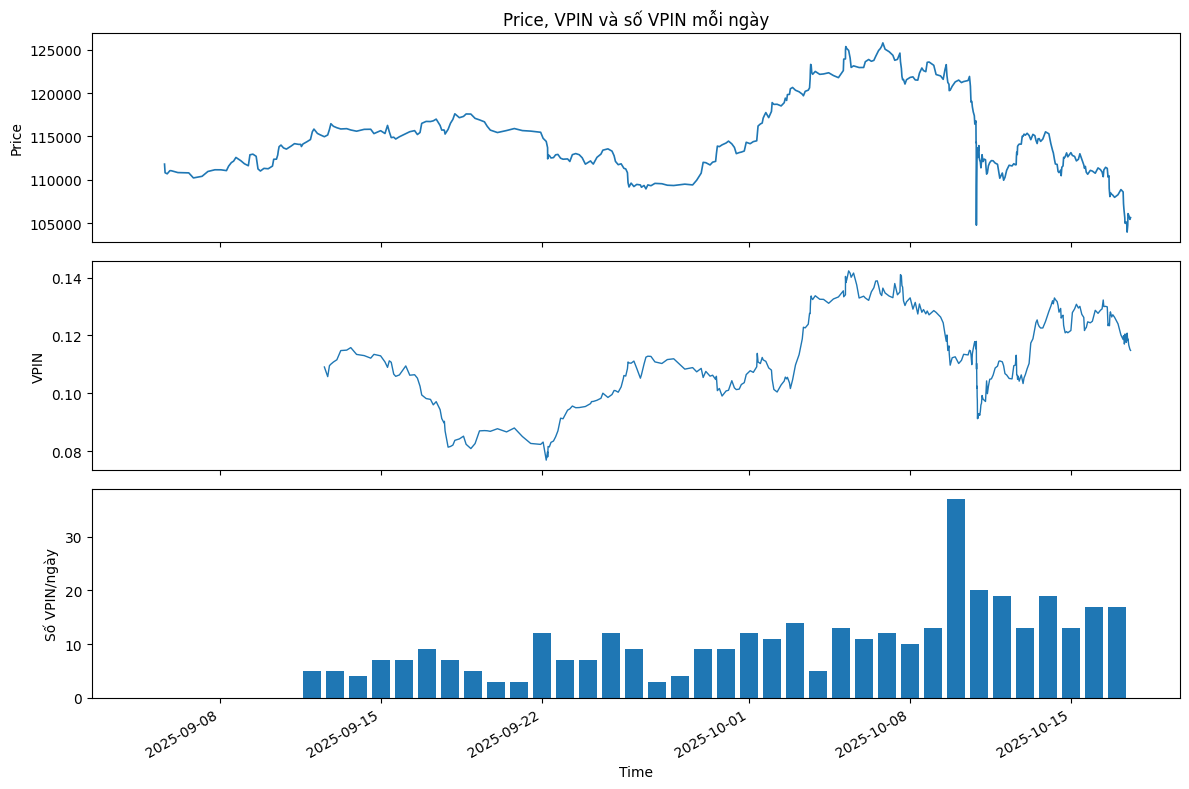

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1. Chuẩn bị dữ liệu
# =========================
df_plot = data.copy()
df_plot["Time"] = pd.to_datetime(df_plot["Time"])
df_plot = df_plot.sort_values("Time").reset_index(drop=True)

# Đặt Time làm index để resample
df_plot = df_plot.set_index("Time")

# Số VPIN một ngày: đếm số quan sát VPIN/ngày
daily_vpin_count = df_plot["VPIN"].resample("D").count()

# (tuỳ chọn) Giá trung bình ngày nếu cần:
# daily_price = df_plot["Price"].resample("D").mean()

# =========================
# 2. Vẽ biểu đồ
# =========================
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# --- (1) Giá ---
axes[0].plot(df_plot.index, df_plot["Price"], linewidth=1.2)
axes[0].set_ylabel("Price")
axes[0].set_title("Price, VPIN và số VPIN mỗi ngày")

# --- (2) VPIN ---
axes[1].plot(df_plot.index, df_plot["VPIN"], linewidth=1.0)
axes[1].set_ylabel("VPIN")

# --- (3) Số VPIN mỗi ngày ---
axes[2].bar(daily_vpin_count.index, daily_vpin_count.values, width=0.8)
axes[2].set_ylabel("Số VPIN/ngày")
axes[2].set_xlabel("Time")

# Format lại trục thời gian cho đẹp
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[2].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_vpin_exhibit(df, start_time, end_time, flash_crash_time=None, title=""):
    """
    df: DataFrame với các cột Time, Price, VPIN, CDF
    start_time, end_time: khoảng thời gian để vẽ
    flash_crash_time: thời điểm flash crash (tùy chọn)
    """

    df_plot = df.copy()
    df_plot["Time"] = pd.to_datetime(df_plot["Time"])
    df_plot = df_plot.sort_values("Time")
    
    # Lọc theo cửa sổ
    mask = (df_plot["Time"] >= start_time) & (df_plot["Time"] <= end_time)
    df_win = df_plot.loc[mask]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # ---------------------
    # Price (trục trái)
    # ---------------------
    ax1.plot(df_win["Time"], df_win["Price"], color="navy", linewidth=2.0, label="Price")
    ax1.set_ylabel("Market Value", fontsize=12, fontweight="bold")
    ax1.grid(True, which="major", axis="both", linestyle="--", alpha=0.3)

    # ---------------------
    # VPIN & CDF (trục phải)
    # ---------------------
    ax2 = ax1.twinx()
    ax2.plot(df_win["Time"], df_win["VPIN"], color="red", linewidth=1.5, label="VPIN")
    ax2.plot(df_win["Time"], df_win["CDF"], color="red", linestyle="--", linewidth=1.5, label="CDF(VPIN)")
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Probability", fontsize=12, fontweight="bold")

    # ---------------------
    # Flash Crash marker
    # ---------------------
    if flash_crash_time is not None:
        ax1.axvline(flash_crash_time, color="black", linestyle="--", linewidth=1.5)
    
    # ---------------------
    # Trục X
    # ---------------------
    ax1.set_xlabel("Time", fontsize=12)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    plt.setp(ax1.get_xticklabels(), rotation=30)

    # ---------------------
    # Title và Legend
    # ---------------------
    plt.title(title, fontsize=14, fontweight="bold")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.tight_layout()
    plt.show()


In [14]:
start_4 = flash_crash_time - pd.Timedelta(days=7)
end_4   = flash_crash_time + pd.Timedelta(days=7)

plot_vpin_exhibit(
    df,
    start_4,
    end_4,
    flash_crash_time=flash_crash_time,
    title="Exhibit 4 – VPIN One Week Before and After the Flash Crash"
)


NameError: name 'flash_crash_time' is not defined

In [ ]:
df = data.sort_values("Time").set_index("Time")

# độ dài mỗi bucket (tính bằng giây)
df["bucket_seconds"] = df.index.to_series().diff().dt.total_seconds()

# xóa giá trị NaN đầu tiên
bucket_seconds = df["bucket_seconds"].iloc[1:]

print("Median:", bucket_seconds.median(), "seconds")
print("Mean  :", bucket_seconds.mean(), "seconds")
print("Min   :", bucket_seconds.min(), "seconds")
print("Max   :", bucket_seconds.max(), "seconds")


Median: 1265.0 seconds
Mean  : 1677.2814232902033 seconds
Min   : 7.0 seconds
Max   : 12838.0 seconds


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1. Chuẩn bị dữ liệu
# =========================
df_plot = df.copy()
df_plot["Time"] = pd.to_datetime(df_plot["Time"])
df_plot = df_plot.sort_values("Time").reset_index(drop=True)

# Đặt Time làm index để resample
df_plot = df_plot.set_index("Time")

# Số VPIN một ngày: đếm số quan sát VPIN/ngày
daily_vpin_count = df_plot["VPIN"].resample("D").count()

# (tuỳ chọn) Giá trung bình ngày nếu cần:
# daily_price = df_plot["Price"].resample("D").mean()

# =========================
# 2. Vẽ biểu đồ
# =========================
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# --- (1) Giá ---
axes[0].plot(df_plot.index, df_plot["Price"], linewidth=1.2)
axes[0].set_ylabel("Price")
axes[0].set_title("Price, VPIN và số VPIN mỗi ngày")

# --- (2) VPIN ---
axes[1].plot(df_plot.index, df_plot["VPIN"], linewidth=1.0)
axes[1].set_ylabel("VPIN")

# --- (3) Số VPIN mỗi ngày ---
axes[2].bar(daily_vpin_count.index, daily_vpin_count.values, width=0.8)
axes[2].set_ylabel("Số VPIN/ngày")
axes[2].set_xlabel("Time")

# Format lại trục thời gian cho đẹp
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[2].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


KeyError: 'Time'

Mean dd_m: -0.008999265022476386
Std dd_m : 0.011094903586101301
Ngưỡng flash crash = -0.04228397578078029
Số candidate (dd_m < mean-3σ): 42
Số flash crash sau khi gom cụm: 2


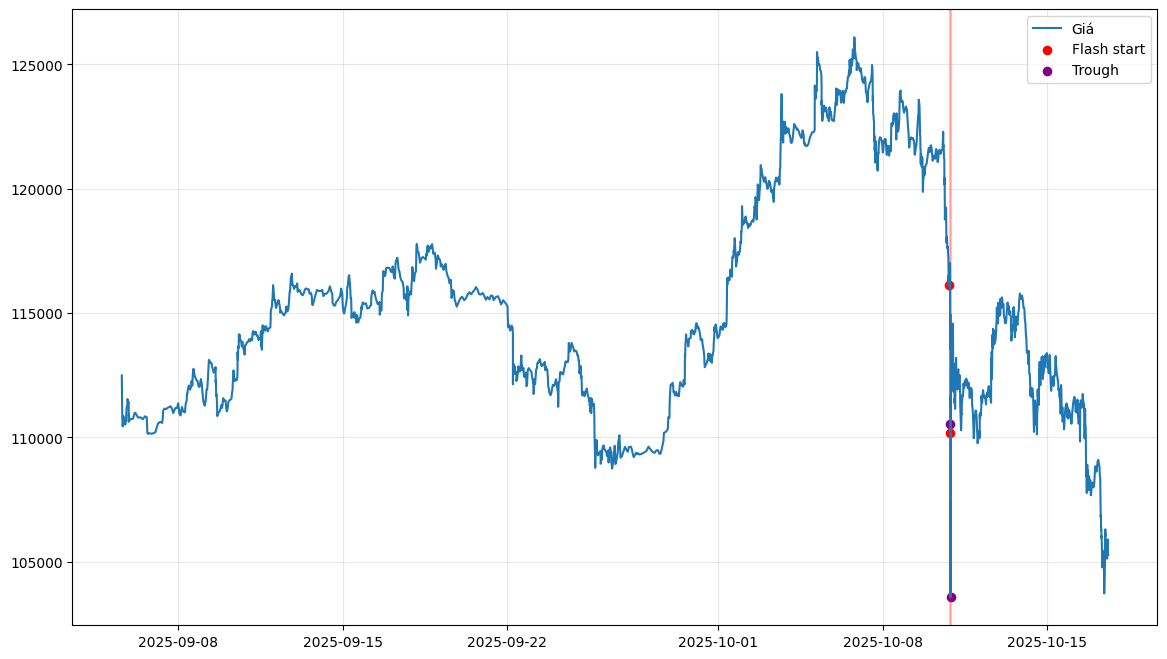


=== Flash Crash Detected ===
[1] Start : 2025-10-10 19:23:48+00:00 — Price = 116106.81
     Trough: 2025-10-10 21:13:32+00:00 — Price = 110549.81
     Giảm  : -4.79%

[2] Start : 2025-10-10 21:13:39+00:00 — Price = 110179.22
     Trough: 2025-10-10 21:20:23+00:00 — Price = 103565.58
     Giảm  : -6.00%



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

tz = df.index.tz
m_fwd = 25   # số bucket nhìn tới để đo drawdown

# ===== HÀM TÍNH FORWARD DRAWDOWN =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m + 1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== TÍNH NGƯỠNG: mean - 3*std =====
mu = dd_m.mean()
sigma = dd_m.std()
threshold = mu - 3 * sigma

print("Mean dd_m:", mu)
print("Std dd_m :", sigma)
print("Ngưỡng flash crash =", threshold)

# ===== LABEL FLASH CRASH: dd_m < mean - 3σ =====
flash_mask = dd_m < threshold
candidate_idx = dd_m[flash_mask].index.sort_values()

print(f"Số candidate (dd_m < mean-3σ): {len(candidate_idx)}")

# ===== GOM CỤM: chỉ lấy 1 flash start cho mỗi cụm rơi =====
starts_list = []
for t in candidate_idx:
    if not starts_list:
        starts_list.append(t)
    else:
        last_pos = df.index.get_loc(starts_list[-1])
        this_pos = df.index.get_loc(t)
        # nếu cách nhau > m_fwd bucket thì coi là sự kiện mới
        if this_pos - last_pos > m_fwd:
            starts_list.append(t)

starts = pd.DatetimeIndex(starts_list)
print(f"Số flash crash sau khi gom cụm: {len(starts)}")

# ===== XÁC ĐỊNH TROUGH CHO MỖI FLASH START =====
troughs = []
for t in starts:
    row = fut_matrix.loc[t].values
    if np.all(np.isnan(row)):
        troughs.append(t)  # fallback: không tìm được -> dùng luôn start
        continue
    j = int(np.nanargmin(row))  # vị trí đáy trong m_fwd
    pos = df.index.get_loc(t)
    trough_pos = pos + (j + 1)
    trough_pos = max(0, min(trough_pos, len(df.index) - 1))
    troughs.append(df.index[trough_pos])

troughs = pd.DatetimeIndex(troughs)

# ===== VẼ FLASH CRASH =====
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.plot(df.index, df['Price'], label='Giá')

# Flash markers
if len(starts):
    ax.scatter(starts, df.loc[starts, 'Price'], color='red', s=35, label='Flash start')
if len(troughs):
    ax.scatter(troughs, df.loc[troughs, 'Price'], color='purple', s=35, label='Trough')

for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax.axvspan(st, tr, alpha=0.15, color='red')

ax.legend()
ax.grid(alpha=.3)
# plt.title("Dữ liệu giao dịch BTCUSDT Flash Crash Detection: dd_m < mean - 3σ (gộp 1 sự kiện/cụm)")
plt.show()

# ===== IN KẾT QUẢ =====
print("\n=== Flash Crash Detected ===")
if len(starts) == 0:
    print("Không phát hiện flash crash theo tiêu chí mean - 3σ.")
else:
    for i, (st, tr) in enumerate(zip(starts, troughs), 1):
        pct_drop = (df.loc[tr, "Price"] / df.loc[st, "Price"] - 1) * 100
        print(f"[{i}] Start : {st} — Price = {df.loc[st,'Price']:.2f}")
        print(f"     Trough: {tr} — Price = {df.loc[tr,'Price']:.2f}")
        print(f"     Giảm  : {pct_drop:.2f}%\n")


Mean(dd_m) = -0.0016133145961994395
Std(dd_m)  = 0.0037787104500744883
Ngưỡng flash (mean - 3σ) = -0.012949445946422904
Số ứng viên dd_m < mean-3σ: 19
Số ứng viên sau filter 5 phút trước: 8

=== KẾT QUẢ FLASH CRASH (mean-3σ + 5 phút + V-shape) ===
Start  (trước khi rơi): 2025-10-10 21:15:40+00:00  — Price = 112156.08
Trough (đáy)          : 2025-10-10 21:20:23+00:00 — Price = 103565.58
End    (sau khi bật)  : 2025-10-10 21:38:42+00:00    — Price = 111455.46
Giảm từ start -> trough : -7.66%
Tăng từ trough -> end   : 7.62%


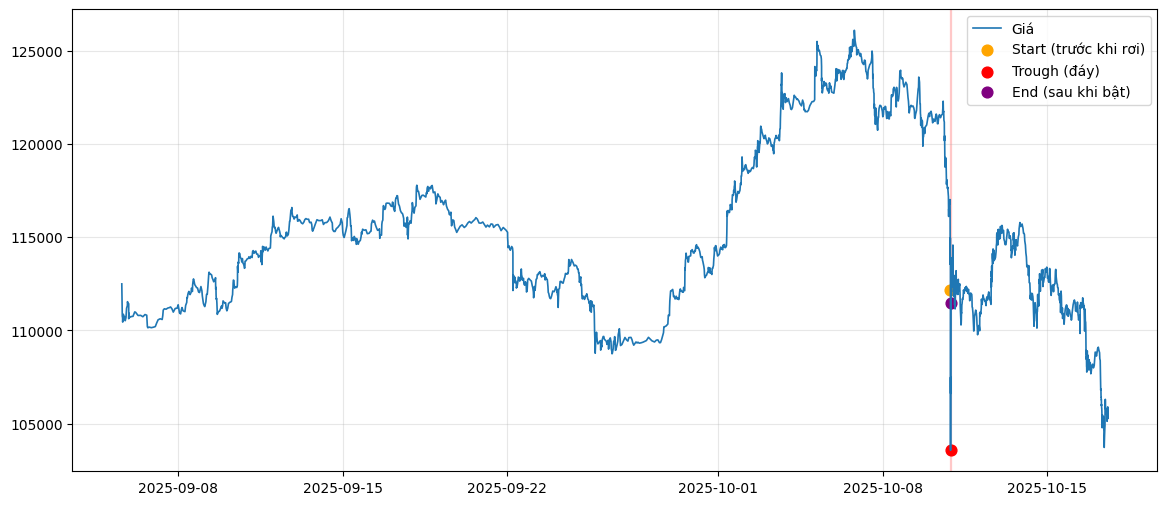

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

# ===== THAM SỐ CHÍNH =====
look_ahead = 3                   # 3 nhóm kế tiếp (như luận văn)
pre_window = pd.Timedelta('5T')  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

# các cửa sổ tinh chỉnh quanh vùng crash (tính theo số nhóm/bucket)
trough_left_span  = 10   # nhìn về trái quanh anchor để tìm đáy
trough_right_span = 10   # nhìn về phải quanh anchor để tìm đáy
start_left_span   = 20   # nhìn về trái quanh đáy để tìm đỉnh trước khi rơi
end_right_span    = 20   # nhìn về phải quanh đáy để tìm đỉnh sau khi bật

# ===== 1. TÍNH dd_m(t) = min_{1<=k<=3} (P_{t+k}/P_t - 1) =====
fut = pd.concat([df['Price'].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df['dd_m'] = (fwd_min / df['Price']) - 1

# ===== 2. NGƯỠNG ĐỘNG: mean(dd_m) - 3*std(dd_m) =====
mu = df['dd_m'].mean()
sigma = df['dd_m'].std()
threshold = mu - 3 * sigma

print("Mean(dd_m) =", mu)
print("Std(dd_m)  =", sigma)
print("Ngưỡng flash (mean - 3σ) =", threshold)

# ===== 3. ỨNG VIÊN: dd_m(t) < mean - 3σ =====
candidates = df[df['dd_m'] < threshold].copy()
print(f"Số ứng viên dd_m < mean-3σ: {len(candidates)}")

start = trough = end = None

if len(candidates) > 0:
    # ===== 4. LỌC THÊM: 5 phút liền trước không rơi quá mạnh =====
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df['Price'].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, 'Price']
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    print(f"Số ứng viên sau filter 5 phút trước: {len(valid_idx)}")

    if len(valid_idx) > 0:
        # ===== 5. CHỌN ANCHOR = ứng viên có dd_m nhỏ nhất =====
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates['dd_m'].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # ===== 6. TÌM ĐÁY: min giá quanh anchor (rớt + bật) =====
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df['Price'].iloc[left_bound:right_bound + 1]

        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # ===== 7. TÌM ĐIỂM TRƯỚC KHI RƠI (START) =====
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df['Price'].iloc[left_start_bound:trough_pos]

        if len(left_segment) > 0:
            start = left_segment.idxmax()
        else:
            start = trough  # fallback

        # ===== 8. TÌM ĐIỂM SAU KHI BẬT LÊN (END) =====
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df['Price'].iloc[trough_pos+1:right_end_bound+1]

        if len(right_segment) > 0:
            end = right_segment.idxmax()
        else:
            end = trough  # fallback

        # Đảm bảo thứ tự thời gian start < trough < end
        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn, dùng anchor logic cũ.")
    else:
        print("Không còn ứng viên nào sau filter 5 phút trước.")

# ===== 9. IN KẾT QUẢ =====
print("\n=== KẾT QUẢ FLASH CRASH (mean-3σ + 5 phút + V-shape) ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    drop_pct  = (df.loc[trough, "Price"] / df.loc[start, "Price"] - 1) * 100
    bounce_pct = (df.loc[end, "Price"] / df.loc[trough, "Price"] - 1) * 100
    print(f"Start  (trước khi rơi): {start}  — Price = {df.loc[start,'Price']:.2f}")
    print(f"Trough (đáy)          : {trough} — Price = {df.loc[trough,'Price']:.2f}")
    print(f"End    (sau khi bật)  : {end}    — Price = {df.loc[end,'Price']:.2f}")
    print(f"Giảm từ start -> trough : {drop_pct:.2f}%")
    print(f"Tăng từ trough -> end   : {bounce_pct:.2f}%")

# ===== 10. VẼ HÌNH ĐỂ CHECK MẮT =====
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Price'], label='Giá', linewidth=1.2)

if start is not None:
    ax.scatter(start, df.loc[start, 'Price'], color='orange', s=60, label='Start (trước khi rơi)')
if trough is not None:
    ax.scatter(trough, df.loc[trough, 'Price'], color='red', s=60, label='Trough (đáy)')
if end is not None:
    ax.scatter(end, df.loc[end, 'Price'], color='purple', s=60, label='End (sau khi bật)')

if start is not None and end is not None:
    ax.axvspan(start, end, color='red', alpha=0.15)

ax.grid(alpha=.3)
ax.legend()
# ax.set_title("Flash crash: điểm trước khi rơi – đáy – sau khi bật (mean-3σ + 5 phút + V-shape)")
plt.show()


Mean(dd_m) = -0.0016133145961994395
Std(dd_m)  = 0.0037787104500744883
Ngưỡng flash (mean - 3σ) = -0.02050686684657188
Số ứng viên dd_m < mean-3σ: 7

=== KẾT QUẢ FLASH CRASH (mean-3σ + V-shape) ===
Start  (trước khi rơi): 2025-10-10 21:15:40+00:00  — Price = 112156.08
Trough (đáy)          : 2025-10-10 21:20:23+00:00 — Price = 103565.58
End    (sau khi bật)  : 2025-10-10 21:38:42+00:00    — Price = 111455.46
Giảm từ start -> trough : -7.66%
Tăng từ trough -> end   : 7.62%


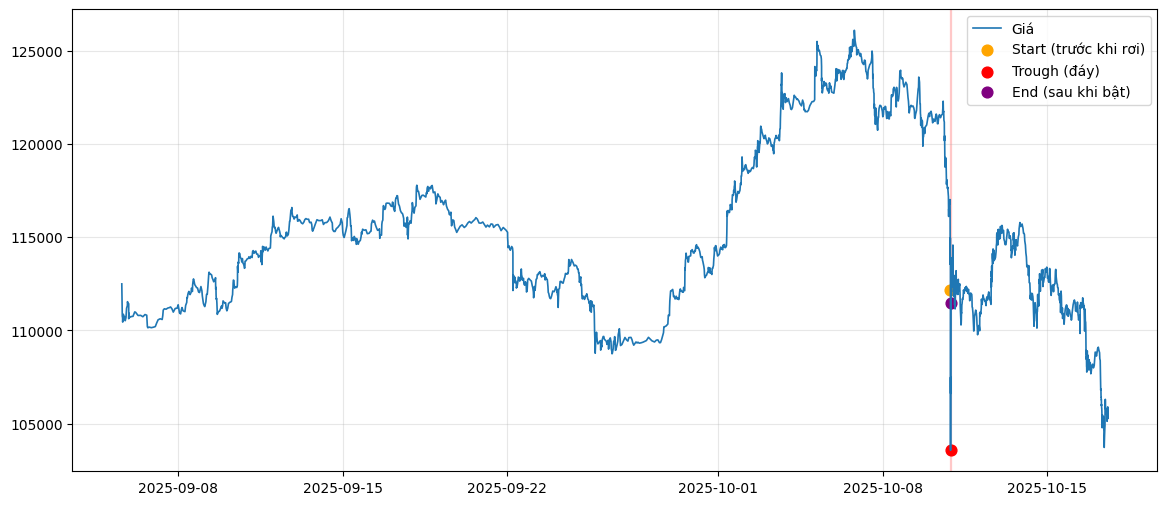

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

# ===== THAM SỐ CHÍNH =====
look_ahead = 3                   # 3 nhóm kế tiếp (như luận văn)

# các cửa sổ tinh chỉnh quanh vùng crash (tính theo số nhóm/bucket)
trough_left_span  = 10   # nhìn về trái quanh anchor để tìm đáy
trough_right_span = 10   # nhìn về phải quanh anchor để tìm đáy
start_left_span   = 20   # nhìn về trái quanh đáy để tìm đỉnh trước khi rơi: P_start = max(P_{t_trough-L..t_trough})
end_right_span    = 20   # nhìn về phải quanh đáy để tìm đỉnh sau khi bật

# ===== 1. TÍNH dd_m(t) = min_{1<=k<=3} (P_{t+k}/P_t - 1) =====
fut = pd.concat([df['Price'].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df['dd_m'] = (fwd_min / df['Price']) - 1

# ===== 2. NGƯỠNG ĐỘNG: mean(dd_m) - 3*std(dd_m) =====
mu = df['dd_m'].mean()
sigma = df['dd_m'].std()
threshold = mu - 5 * sigma

print("Mean(dd_m) =", mu)
print("Std(dd_m)  =", sigma)
print("Ngưỡng flash (mean - 3σ) =", threshold)

# ===== 3. ỨNG VIÊN: dd_m(t) < mean - 3σ =====
candidates = df[df['dd_m'] < threshold].copy()
print(f"Số ứng viên dd_m < mean-3σ: {len(candidates)}")

start = trough = end = None

if len(candidates) > 0:
    # ===== 4. CHỌN ANCHOR = ứng viên có dd_m nhỏ nhất =====
    anchor = candidates['dd_m'].idxmin()
    anchor_pos = df.index.get_loc(anchor)

    # ===== 5. TÌM ĐÁY: min giá quanh anchor (rớt + bật) =====
    left_bound  = max(0, anchor_pos - trough_left_span)
    right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
    local_segment = df['Price'].iloc[left_bound:right_bound + 1]

    trough = local_segment.idxmin()
    trough_pos = df.index.get_loc(trough)

    # ===== 6. TÌM ĐIỂM TRƯỚC KHI RƠI (START) =====
    # P_start = max(P_{t_trough-L} ... P_{t_trough})
    left_start_bound = max(0, trough_pos - start_left_span)
    left_segment = df['Price'].iloc[left_start_bound:trough_pos+1]  # bao gồm cả t_trough

    if len(left_segment) > 0:
        start = left_segment.idxmax()
    else:
        start = trough  # fallback

    # ===== 7. TÌM ĐIỂM SAU KHI BẬT LÊN (END) =====
    right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
    right_segment = df['Price'].iloc[trough_pos+1:right_end_bound+1]

    if len(right_segment) > 0:
        end = right_segment.idxmax()
    else:
        end = trough  # fallback

    # Đảm bảo thứ tự thời gian start < trough < end (nếu không thì cảnh báo)
    if not (start < trough < end):
        print("Cảnh báo: thứ tự start–trough–end không chuẩn, có thể cần chỉnh lại các span.")
else:
    print("Không có ứng viên nào thỏa dd_m < mean-3σ.")

# ===== 8. IN KẾT QUẢ =====
print("\n=== KẾT QUẢ FLASH CRASH (mean-3σ + V-shape) ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    drop_pct  = (df.loc[trough, "Price"] / df.loc[start, "Price"] - 1) * 100
    bounce_pct = (df.loc[end, "Price"] / df.loc[trough, "Price"] - 1) * 100
    print(f"Start  (trước khi rơi): {start}  — Price = {df.loc[start,'Price']:.2f}")
    print(f"Trough (đáy)          : {trough} — Price = {df.loc[trough,'Price']:.2f}")
    print(f"End    (sau khi bật)  : {end}    — Price = {df.loc[end,'Price']:.2f}")
    print(f"Giảm từ start -> trough : {drop_pct:.2f}%")
    print(f"Tăng từ trough -> end   : {bounce_pct:.2f}%")

# ===== 9. VẼ HÌNH ĐỂ CHECK MẮT =====
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Price'], label='Giá', linewidth=1.2)

if start is not None:
    ax.scatter(start, df.loc[start, 'Price'], color='orange', s=60, label='Start (trước khi rơi)')
if trough is not None:
    ax.scatter(trough, df.loc[trough, 'Price'], color='red', s=60, label='Trough (đáy)')
if end is not None:
    ax.scatter(end, df.loc[end, 'Price'], color='purple', s=60, label='End (sau khi bật)')

if start is not None and end is not None:
    ax.axvspan(start, end, color='red', alpha=0.15)

ax.grid(alpha=.3)
ax.legend()
# ax.set_title("Flash crash: điểm trước khi rơi – đáy – sau khi bật (mean-3σ + V-shape)")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1. Chuẩn bị dữ liệu
# =========================
df_plot = df.copy()
df_plot["Time"] = pd.to_datetime(df_plot["Time"])
df_plot = df_plot.sort_values("Time").reset_index(drop=True)

# Đặt Time làm index để resample
df_plot = df_plot.set_index("Time")

# Số VPIN một ngày: đếm số quan sát VPIN/ngày
daily_vpin_count = df_plot["VPIN"].resample("D").count()

# (tuỳ chọn) Giá trung bình ngày nếu cần:
# daily_price = df_plot["Price"].resample("D").mean()

# =========================
# 2. Vẽ biểu đồ
# =========================
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# --- (1) Giá ---
axes[0].plot(df_plot.index, df_plot["Price"], linewidth=1.2)
axes[0].set_ylabel("Price")
axes[0].set_title("Price, VPIN và số VPIN mỗi ngày")

# --- (2) VPIN ---
axes[1].plot(df_plot.index, df_plot["VPIN"], linewidth=1.0)
axes[1].set_ylabel("VPIN")

# --- (3) Số VPIN mỗi ngày ---
axes[2].bar(daily_vpin_count.index, daily_vpin_count.values, width=0.8)
axes[2].set_ylabel("Số VPIN/ngày")
axes[2].set_xlabel("Time")

# Format lại trục thời gian cho đẹp
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(axes[2].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.show()


KeyError: 'Time'

In [ ]:
import pandas as pd
import numpy as np

df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

# ===== THAM SỐ =====
look_ahead = 3                 # 3 nhóm kế tiếp (như luận văn)
pre_window = pd.Timedelta('5T')  # 5 phút liền trước
pre_trend_tol = -0.01          # không được rơi quá 1% trong 5 phút trước

# ===== 1. TÍNH dd_m(t) = min_{1<=k<=3} (P_{t+k}/P_t - 1) =====
fut = pd.concat([df['Price'].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df['dd_m'] = (fwd_min / df['Price']) - 1

# ===== 2. NGƯỠNG ĐỘNG: mean(dd_m) - 3*std(dd_m) =====
mu = df['dd_m'].mean()
sigma = df['dd_m'].std()
threshold = mu - 3 * sigma

print("Mean(dd_m) =", mu)
print("Std(dd_m)  =", sigma)
print("Ngưỡng flash = mean - 3σ =", threshold)

# ===== 3. ỨNG VIÊN: dd_m(t) < mean - 3σ =====
candidates = df[df['dd_m'] < threshold].copy()
print(f"Số ứng viên dd_m < mean-3σ: {len(candidates)}")

if len(candidates) == 0:
    print("\nKhông có điểm nào thỏa điều kiện dd_m < mean - 3σ.")
    start = None
    trough = None
else:
    # ===== 4. LỌC THÊM: 5 phút liền trước không được rơi quá mạnh =====
    valid_idx = []
    for t in candidates.index:
        # cửa sổ [t - 5 phút, t]
        t0 = t - pre_window
        hist = df['Price'].loc[t0:t]   # các giá trong 5 phút trước đến thời điểm t
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]         # giá tại đầu cửa sổ 5 phút
        p_now = df.loc[t, 'Price']
        pre_ret = p_now / p_past - 1   # % thay đổi trong 5 phút trước

        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    print(f"Số ứng viên sau filter 5 phút trước: {len(valid_idx)}")

    if len(valid_idx) == 0:
        print("\nKhông có ứng viên nào qua được filter 5 phút trước.")
        start = None
        trough = None
    else:
        # ===== 5. START = điểm có dd_m nhỏ nhất trong số valid_idx =====
        valid_candidates = candidates.loc[valid_idx]
        start = valid_candidates['dd_m'].idxmin()

        # ===== 6. TROUGH = giá thấp nhất trong 3 nhóm tiếp theo sau start =====
        pos = df.index.get_loc(start)
        fut_prices = df['Price'].iloc[pos+1 : pos+1+look_ahead]

        if len(fut_prices) == 0:
            trough = None
        else:
            trough = fut_prices.idxmin()

# ===== 7. IN KẾT QUẢ =====
print("\n=== KẾT QUẢ FLASH CRASH (mean-3σ + 5 phút trước) ===")
if start is None or trough is None:
    print("Không phát hiện flash crash.")
else:
    pct_drop = (df.loc[trough, "Price"] / df.loc[start, "Price"] - 1) * 100
    print(f"Start  : {start}  — Price = {df.loc[start,'Price']:.2f}")
    print(f"Trough : {trough} — Price = {df.loc[trough,'Price']:.2f}")
    print(f"Giảm   : {pct_drop:.2f}%")


Mean(dd_m) = -0.0016133145961994395
Std(dd_m)  = 0.0037787104500744883
Ngưỡng flash = mean - 3σ = -0.012949445946422904
Số ứng viên dd_m < mean-3σ: 19
Số ứng viên sau filter 5 phút trước: 8

=== KẾT QUẢ FLASH CRASH (mean-3σ + 5 phút trước) ===
Start  : 2025-10-10 21:18:28+00:00  — Price = 109589.37
Trough : 2025-10-10 21:19:40+00:00 — Price = 105815.10
Giảm   : -3.44%


In [ ]:

# ===== BẢNG TÓM TẮT =====
summary = pd.DataFrame({'buckets_per_day': per_day}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())

# =====================================================================
#  ➤ TẠO LABEL TỪ starts (3 bucket trước flash crash = 1)
# =====================================================================
df["label"] = 0
lookback = 3

for st in starts:
    pos = df.index.get_loc(st)
    lb = max(0, pos - lookback)
    df.iloc[lb:pos+1, df.columns.get_loc("label")] = 1

print("\nlabel value_counts:")
print(df["label"].value_counts())

# =====================================================================
#  ➤ RANDOM FOREST: chuẩn bị feature + train + p_smooth
# =====================================================================
COOLDOWN  = pd.Timedelta("15min")
MATCH_WIN = pd.Timedelta("20min")
TEST_SIZE = 0.2

# # loại một số cột không nên dùng làm feature nếu có
# drop_cols = [
#     "label",
#     "rf_prob", "logreg_prob", "xgb_prob",
#     "prob_smooth", "p_raw", "p_smooth",
#     "weak_price", "high_vpin", "wide_spread",
# ]

# feature_cols = [c for c in df.columns if c not in drop_cols]
# loại một số cột không nên dùng làm feature nếu có


feature_cols =  [
    # 'BidPrice', 'AskPrice', 'Volume',
       'VPIN', 
       'CDF', 
       'Roll', 'RollImpact', 'Returns', 'AmihudLambda',
    #    'BidAskSpread'
       ]
# 'SpreadChangeSign', 'RealizedVolatility']

print("\nSố feature:", len(feature_cols))
print("Feature:", feature_cols)

X = df[feature_cols].values
y = df["label"].values
times = df.index

print("X:", X.shape)
print("y:", y.shape, "— số label=1:", y.sum(), "số label=0:", (y == 0).sum())

n = len(df)
split_idx = int((1 - TEST_SIZE) * n)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
t_train, t_test = times[:split_idx], times[split_idx:]

print("Train size:", X_train.shape[0], "— Test size:", X_test.shape[0])

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_prob_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== Random Forest – bucket-level (thr=0.5, chỉ để tham khảo) ===")
print(classification_report(y_test, y_pred_test))

# Xác suất cho toàn bộ df + smoothing
rf_prob_full = rf.predict_proba(X)[:, 1]
df["rf_prob"]  = rf_prob_full
df["p_smooth"] = df["rf_prob"].rolling(5, min_periods=1).mean()

print("\nMô tả phân phối p_smooth:")
print(df["p_smooth"].describe())

# =====================================================================
#  ➤ HÀM TẠO ALERT + EVALUATE THRESHOLD (EVENT-LEVEL)
# =====================================================================
def gen_alerts_from_thr(thr: float) -> pd.DatetimeIndex:
    alerts = []
    last = None
    for t, p in zip(df.index, df["p_smooth"].values):
        if p >= thr:
            if (last is None) or (t - last >= COOLDOWN):
                alerts.append(t)
                last = t
    return pd.DatetimeIndex(alerts)

def eval_threshold(thr: float):
    alerts = gen_alerts_from_thr(thr)

    # alerts/ngày
    if len(alerts):
        days = alerts.normalize()
        counts = pd.Series(1, index=days).groupby(level=0).size()
        alerts_per_day = counts.mean()
    else:
        alerts_per_day = 0.0

    tp = fp = 0
    matched = set()
    for a in alerts:
        cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
        if cand:
            s0 = min(cand, key=lambda x: abs(a - x))
            matched.add(s0)
            tp += 1
        else:
            fp += 1

    fn = len(starts) - tp
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f2   = (5 * prec * rec) / (4 * prec + rec + 1e-9) if (prec + rec) > 0 else 0.0

    return {
        "thr": thr,
        "n_alerts": len(alerts),
        "alerts_per_day": alerts_per_day,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": prec,
        "recall": rec,
        "f2": f2,
        "alerts": alerts,
    }


NameError: name 'per_day' is not defined

In [ ]:

# =====================================================================
#  ➤ QUÉT NGƯỠNG THEO F2
# =====================================================================
q90  = float(df["p_smooth"].quantile(0.90))
q999 = float(df["p_smooth"].quantile(0.999))
if q90 == q999:
    q999 = float(df["p_smooth"].max())

thresholds = np.linspace(q90, q999, 40)
print(f"\nScan threshold range: {thresholds[0]:.6f} → {thresholds[-1]:.6f}")

rows = []
best = None
for thr in thresholds:
    res = eval_threshold(thr)
    rows.append(res)
    if (best is None) or (res["f2"] > best["f2"]):
        best = res

res_df = pd.DataFrame(rows)
print("\n== TOP 10 NGƯỠNG TỐT NHẤT THEO EVENT-LEVEL F2 (ưu tiên recall) ==")
print(
    res_df.sort_values("f2", ascending=False)[
        ["thr", "n_alerts", "alerts_per_day", "tp", "fp", "fn", "precision", "recall", "f2"]
    ].head(10)
)

print("\n== NGƯỠNG ĐƯỢC CHỌN (best theo F2) ==")
print(f"Threshold = {best['thr']:.6f}")
print(f"Số ALERT  = {best['n_alerts']} (≈ {best['alerts_per_day']:.2f} alerts/ngày)")
print(f"TP={best['tp']}, FP={best['fp']}, FN={best['fn']}")
print(f"Event-level precision = {best['precision']:.3f}")
print(f"Event-level recall    = {best['recall']:.3f}")
print(f"Event-level F2        = {best['f2']:.3f}")

final_alerts = best["alerts"]
BEST_THR = best["thr"]


KeyError: 'p_smooth'

NameError: name 'starts' is not defined

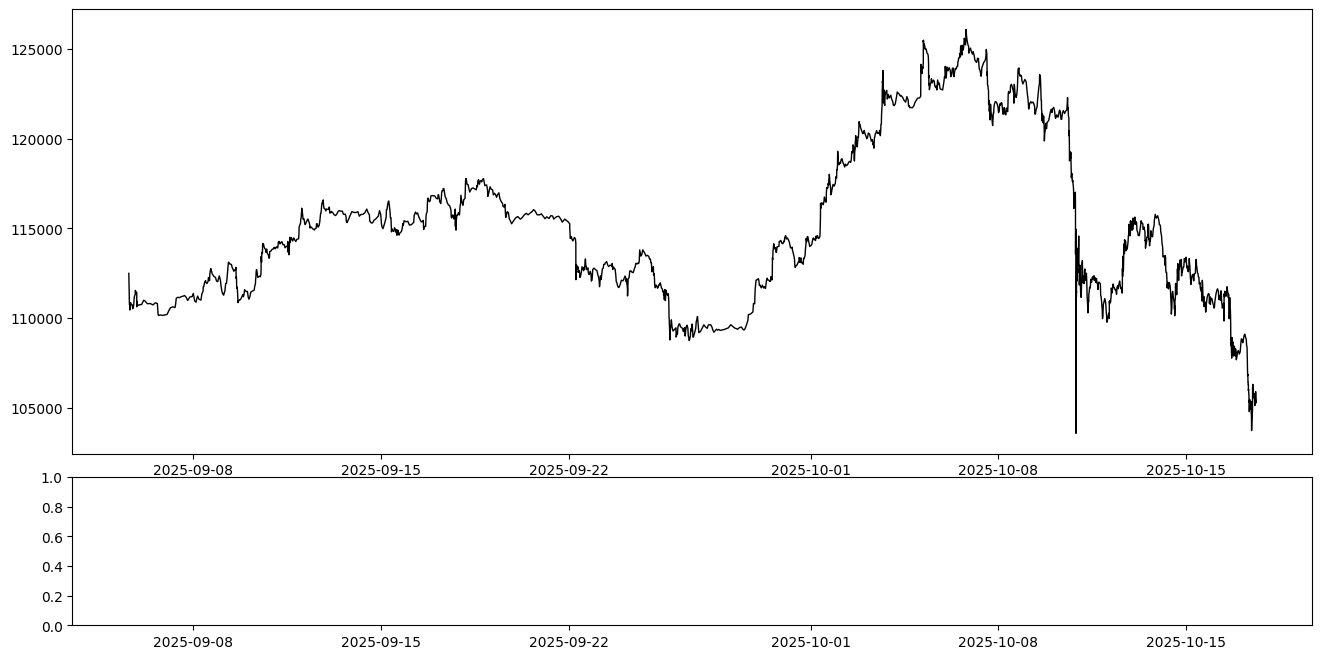

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.08)

ax_p = fig.add_subplot(gs[0, 0])
ax_a = fig.add_subplot(gs[1, 0], sharex=ax_p)

# ===============================
#  PANEL 1 – GIÁ + FLASH + CẢNH BÁO
# ===============================
ax_p.plot(df.index, df["Price"], color="black", label="Giá", linewidth=1)

# Điểm bắt đầu flash crash
if len(starts):
    ax_p.scatter(starts, df.loc[starts, "Price"],
                 color="red", s=45, label="Bắt đầu flash crash", zorder=3)

# Đáy
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs, "Price"],
                 color="purple", s=45, label="Đáy", zorder=3)

# Tô vùng từ start → trough
for st, tr in zip(starts, troughs):
    if tr >= st:
        ax_p.axvspan(st, tr, color="red", alpha=0.12)

# Cảnh báo của Random Forest
if len(final_alerts):
    ax_p.scatter(final_alerts, df.loc[final_alerts, "Price"],
                 color="orange", s=40, marker="x", linewidths=2,
                 label=f"Cảnh báo RF (ngưỡng={BEST_THR:.3f})", zorder=4)

ax_p.set_ylabel("Giá")
ax_p.legend(loc="upper left", frameon=False)
ax_p.grid(alpha=0.3)

# Ẩn nhãn X ở panel trên
ax_p.tick_params(labelbottom=False)

# ===============================
#  PANEL 2 – XÁC SUẤT p_smooth + NGƯỠNG
# ===============================
ax_a.plot(df.index, df["p_smooth"], color="blue", alpha=0.4, label="p_smooth (RF)")
ax_a.axhline(BEST_THR, color="orange", linestyle="--",
             label=f"Ngưỡng = {BEST_THR:.3f}")

# Đánh dấu vị trí alert
if len(final_alerts):
    ax_a.scatter(final_alerts, df.loc[final_alerts, "p_smooth"],
                 color="orange", marker="x", s=35)

ax_a.set_ylabel("Xác suất RF")
ax_a.set_xlabel("Thời gian")
ax_a.grid(alpha=0.25)
ax_a.legend(frameon=False)

# ===============================
#  CHỈNH LẠI LAYOUT – KHÔNG ĐÈ X-LABEL
# ===============================
fig.subplots_adjust(
    bottom=0.12,
    left=0.07,
    right=0.98,
    top=0.96,
    hspace=0.05
)

# Xoay nhãn thời gian ở panel dưới
for label in ax_a.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

plt.show()
